In [149]:
import random
import string
import os

from cryptography.hazmat.primitives.asymmetric import rsa , padding
from cryptography.hazmat.primitives import hashes

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


In [150]:
def generate_random_files(byte_size):
    random_text = ''.join(random.choices(string.ascii_letters + string.digits + string.punctuation + ' ', k=byte_size))
    return random_text
def write_to_file(directory,filename, byte_size):
    
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path=os.path.join(directory,filename)

    random_text=generate_random_files(byte_size)

    with open(file_path,'w') as file:
        file.write(random_text)


sizes=[8, 64, 512, 4096, 32768, 262144, 2097152]

directory='random_files'

for size in sizes:
    filename = f'random_text_{size}.txt'
    write_to_file(directory,filename,size)



In [151]:
rsa_directory='random_rsa_files'
def generate_rsa_files():
    RSA_sizes=[2 , 4, 8, 16, 32, 64, 128]
    for size in RSA_sizes:

        filename = f'random_text_{size}.txt'
        write_to_file(rsa_directory,filename,size)

Public and Private Key generation

In [152]:
private_key = rsa.generate_private_key(
    public_exponent=65537,
    key_size=2048
)

public_key=private_key.public_key()


Encryption

In [153]:
def rsa_encryption(plaintext, public_key):
    start=timer()
    ciphertext=public_key.encrypt(
        plaintext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),

            algorithm=hashes.SHA256(),

            label=None
        )
    )

    end=timer()
    encryption_time :float = (end-start)*1000   # ms

    return encryption_time, ciphertext


Decryption 

In [154]:
def rsa_decryption(ciphertext, private_key):
    start= timer()
    plaintext = private_key.decrypt(
        ciphertext,
        padding.OAEP(
            mgf=padding.MGF1(algorithm=hashes.SHA256()),

            algorithm=hashes.SHA256(),

            label=None
        )
    )
    end= timer()
    decryption_time : float = (end-start) *1000 # ms 
    
    return decryption_time

Plaintext reading from files


In [155]:
def rsa_encrypt_decrypt(plaintext):

    encrypt_time, ciphertext = rsa_encryption(plaintext, public_key)

    decrypt_time = rsa_decryption(ciphertext, private_key)

    return encrypt_time, decrypt_time




In [156]:
def plot_rsa_performance(file_info):

    file_sizes = sorted(file_info.keys())

    mean_encrypt = [file_info[size][0] for size in file_sizes]
    mean_decrypt = [file_info[size][1] for size in file_sizes]

    var_encrypt = [file_info[size][2] for size in file_sizes]
    var_decrypt = [file_info[size][3] for size in file_sizes]

    stderr_encrypt = [file_info[size][4] for size in file_sizes]
    stderr_decrypt = [file_info[size][5] for size in file_sizes]


    x_positions = range(len(file_sizes))  # Evenly spaced x positions

    plt.figure(figsize=(10, 6))
    
    # Média com barras de erro    
    scale_factor = 7
    plt.errorbar(x_positions, mean_encrypt, yerr=np.array(stderr_encrypt) * scale_factor, fmt='o-', capsize=5, label="Encryption Time (Avg ± StdErr)", color="blue")
    plt.errorbar(x_positions, mean_decrypt, yerr=np.array(stderr_decrypt) * scale_factor, fmt='s-', capsize=5, label="Decryption Time (Avg ± StdErr)", color="red")

    # Variância como área sombreada
    plt.fill_between(x_positions, np.array(mean_encrypt) - np.sqrt(var_encrypt), np.array(mean_encrypt) + np.sqrt(var_encrypt), color="blue", alpha=0.2)
    plt.fill_between(x_positions, np.array(mean_decrypt) - np.sqrt(var_decrypt), np.array(mean_decrypt) + np.sqrt(var_decrypt), color="red", alpha=0.2)


    plt.xticks(x_positions, file_sizes, rotation=45, ha="right")  # Rotate labels for readability
    plt.xlabel("Files")
    plt.ylabel("Time (s)")
    plt.title("RSA Encryption & Decryption Time by File")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [157]:
def process_file_info(file_info):

    final_file_info = {}

    for file_size, times in file_info.items():

        encrypt_times = np.array(times["encrypt_times"])
        decrypt_times = np.array(times["decrypt_times"])

        mean_encrypt = np.mean(encrypt_times)
        mean_decrypt = np.mean(decrypt_times)

        var_encrypt = np.var(encrypt_times, ddof=1)  # ddof=1 para variância amostral
        var_decrypt = np.var(decrypt_times, ddof=1)

        stderr_encrypt = np.sqrt(var_encrypt / len(encrypt_times))  # Erro padrão
        stderr_decrypt = np.sqrt(var_decrypt / len(decrypt_times))

        final_file_info[file_size] = [mean_encrypt, mean_decrypt, var_encrypt, var_decrypt, stderr_encrypt, stderr_decrypt]

    return final_file_info

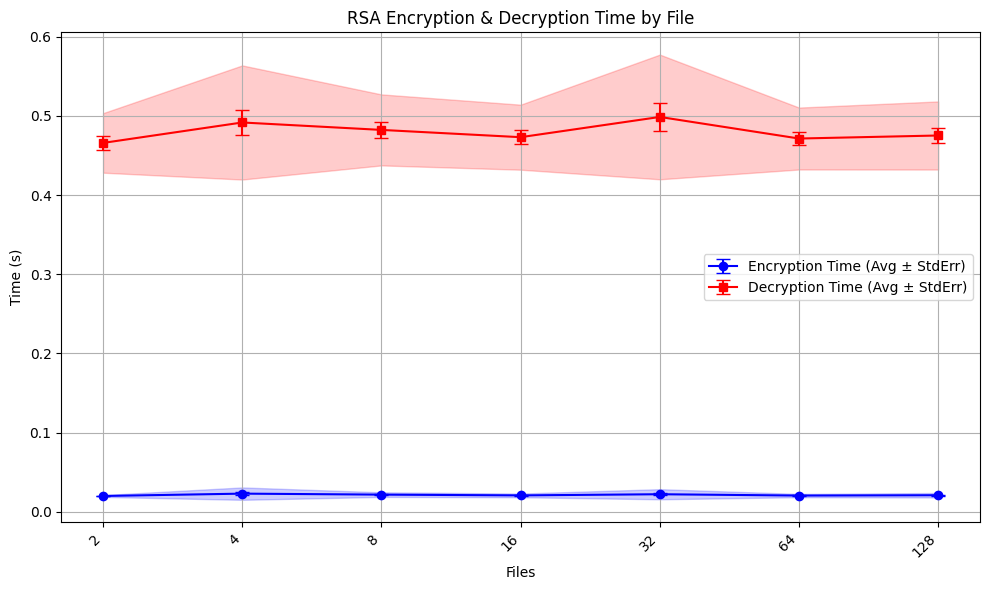

In [ ]:
def get_same_file_info():

    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})
    
    for filename in os.listdir(rsa_directory):

        filepath= os.path.join(rsa_directory,filename)
        
        if os.path.isfile(filepath):

            with open(filepath, "r", encoding="utf-8") as file:
                
                plaintext=file.read().encode()

            file_size = os.path.getsize(filepath)

            for _ in range(1000):
                e_time, d_time = rsa_encrypt_decrypt(plaintext)

                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)

    return file_info




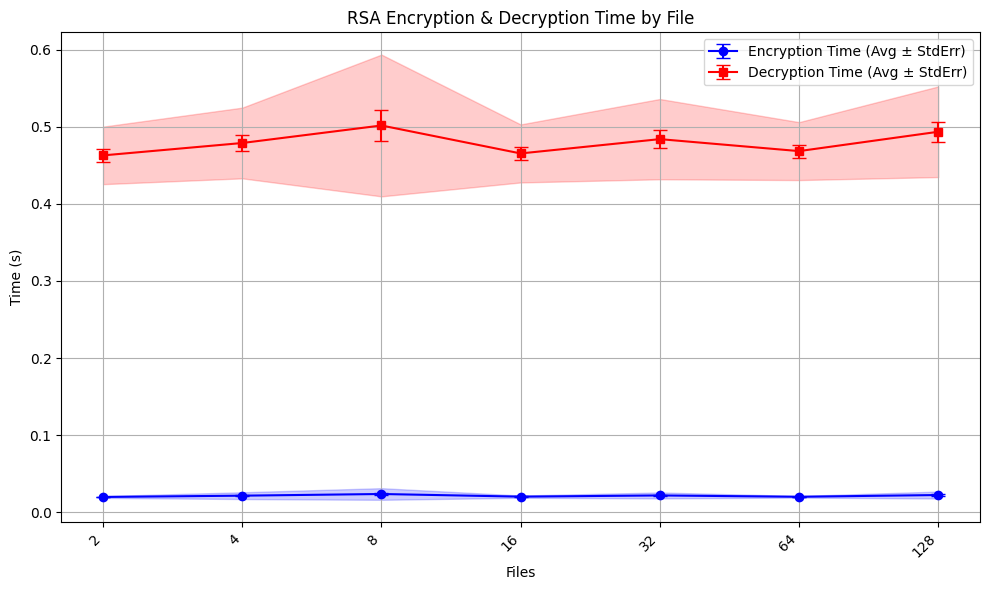

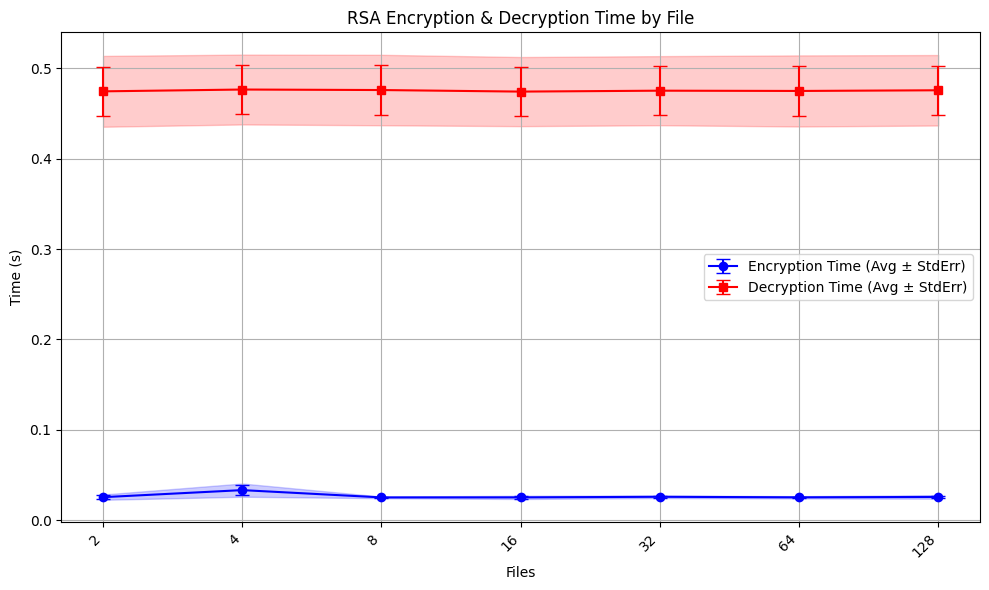

In [ ]:
def get_rand_file_info():
    file_info = defaultdict(lambda: {"encrypt_times": [], "decrypt_times": []})

    for i in range(100):
        
        generate_rsa_files()
        for filename in os.listdir(rsa_directory):

            filepath= os.path.join(rsa_directory,filename)
            
            if os.path.isfile(filepath):

                with open(filepath, "r", encoding="utf-8") as file:
                    
                    plaintext=file.read().encode()

                file_size = os.path.getsize(filepath)

                e_time, d_time = rsa_encrypt_decrypt(plaintext)
                file_info[file_size]["encrypt_times"].append(e_time)
                file_info[file_size]["decrypt_times"].append(d_time)
    return file_info




In [ ]:
file_info=get_same_file_info()
final_file_info=process_file_info(file_info)
plot_rsa_performance(final_file_info)


file_info= get_rand_file_info()
final_file_info=process_file_info(file_info)
plot_rsa_performance(final_file_info)